In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [75]:
df = pd.read_csv("A2_data.csv")

In [76]:
df.head()

,alpha,delta,u,g,r,i,z,field_ID,MJD,redshift,plate,class
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,79,56064,-0.001584,854,GALAXY
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,119,53727,-0.824700,3292,GALAXY
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,120,54883,-0.418000,5888,GALAXY
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,214,51783,5.953000,536,GALAXY
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,137,56069,0.846000,9427,GALAXY


In [77]:
df_clean = df.drop(['field_ID','MJD','plate'], axis=1) # the id columns is not needed for estimation

In [78]:
# find where the g is negative
print( df_clean[df_clean['g'] < 0] )
print( df_clean[df_clean['u'] < 0] )
print( df_clean[df_clean['z'] < 0] )

            alpha     delta       u       g        r         i       z  \
79543  224.006526 -0.624304 -9999.0 -9999.0  18.1656  18.01675 -9999.0   

       redshift class  
79543     1.828  STAR  
            alpha     delta       u       g        r         i       z  \
79543  224.006526 -0.624304 -9999.0 -9999.0  18.1656  18.01675 -9999.0   

       redshift class  
79543     1.828  STAR  
            alpha     delta       u       g        r         i       z  \
79543  224.006526 -0.624304 -9999.0 -9999.0  18.1656  18.01675 -9999.0   

       redshift class  
79543     1.828  STAR  


In [79]:
g_column = df_clean['g']
u_column = df_clean['u']
z_column = df_clean['z']

In [80]:
# round up the values in the g column
g_column = g_column.round(0)
u_column = u_column.round(0)
z_column = z_column.round(0)

In [81]:
print(g_column.unique())
print(u_column.unique())
print(z_column.unique())

[   22.    23.    24.    18.    21.    20.    19.    17.    25.    26.
    15.    16.    14.    27.    29.    13.    11.    28.    30.    12.
    32.    31.    10. -9999.]
[   24.    25.    22.    19.    23.    21.    26.    20.    27.    18.
    17.    16.    29.    28.    15.    12.    14.    31.    33.    11.
    13. -9999.]
[   19.    22.    16.    20.    17.    18.    21.    23.    15.    14.
    12.    24.    13.    25.    11.    10.    26.    28.    29.    27.
 -9999.]


In [82]:
# drop row 79543
df_clean = df_clean.drop(79543, axis=0)

In [83]:
df_clean.describe()

,alpha,delta,u,g,r,i,z,redshift
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,0.001360
std,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,3.002684
min,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,-12.160000
25%,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,-2.027000
50%,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,0.012340
75%,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,2.040000
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,14.160000


In [84]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   alpha     99999 non-null  float64
 1   delta     99999 non-null  float64
 2   u         99999 non-null  float64
 3   g         99999 non-null  float64
 4   r         99999 non-null  float64
 5   i         99999 non-null  float64
 6   z         99999 non-null  float64
 7   redshift  99999 non-null  float64
 8   class     99999 non-null  object 
dtypes: float64(8), object(1)
memory usage: 7.6+ MB


In [85]:
df_clean.nunique().to_frame().transpose()

,alpha,delta,u,g,r,i,z,redshift,class
0,99996,99998,93747,92650,91900,92018,92006,14815,3


In [86]:
quantity_class = df_clean['class'].value_counts().to_frame().rename(index=str, columns={'class': 'Class'})
quantity_class

,Class
GALAXY,59445
STAR,21593
QSO,18961


In [87]:
df_clean.corr()

C:\Users\KYRIAKOS ARISTIDOU\AppData\Local\Temp\ipykernel_6824\1863484124.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_clean.corr()


,alpha,delta,u,g,r,i,z,redshift
alpha,1.000000,0.138698,-0.000222,-0.014118,-0.022079,-0.023577,-0.025160,-0.001231
delta,0.138698,1.000000,-0.026845,-0.007077,-0.006845,-0.004488,-0.006286,0.001705
u,-0.000222,-0.026845,1.000000,0.853350,0.728681,0.618346,0.545760,-0.006827
g,-0.014118,-0.007077,0.853350,1.000000,0.932996,0.847046,0.775302,-0.005258
r,-0.022079,-0.006845,0.728681,0.932996,1.000000,0.962868,0.919114,-0.003897
i,-0.023577,-0.004488,0.618346,0.847046,0.962868,1.000000,0.971546,-0.002688
z,-0.025160,-0.006286,0.545760,0.775302,0.919114,0.971546,1.000000,-0.000693
redshift,-0.001231,0.001705,-0.006827,-0.005258,-0.003897,-0.002688,-0.000693,1.000000


C:\Users\KYRIAKOS ARISTIDOU\AppData\Local\Temp\ipykernel_6824\3518685868.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_clean.corr(),annot=True,cmap='twilight_shifted')


<AxesSubplot: >

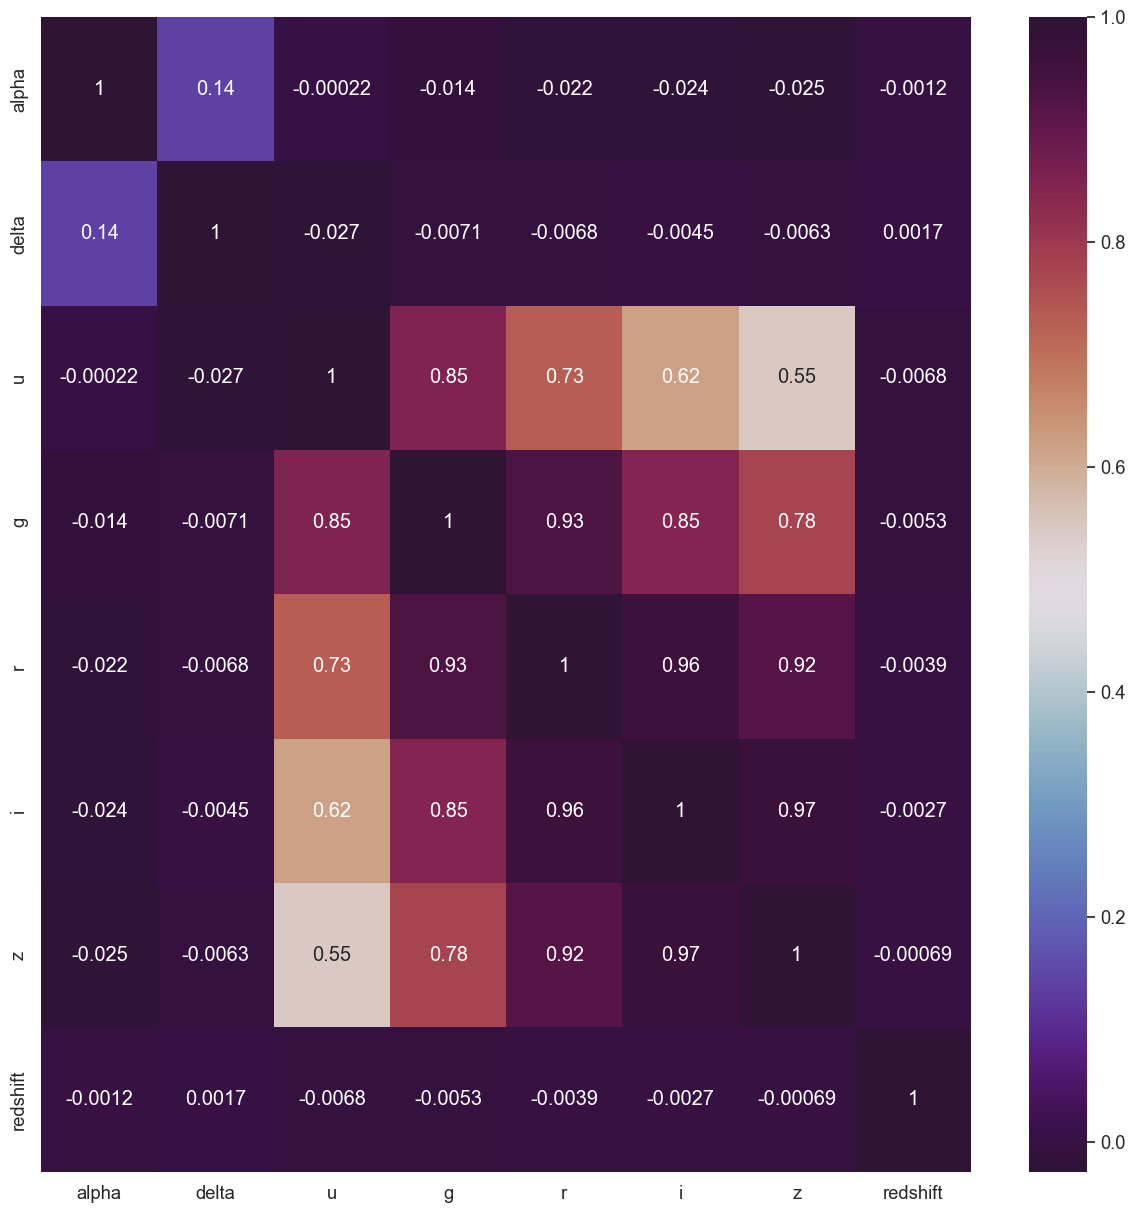

In [88]:
plt.figure(figsize=(15,15))
sns.heatmap(df_clean.corr(),annot=True,cmap='twilight_shifted')

In [89]:
features = df_clean.drop(['class'],axis=1)
labels =df_clean['class']

C:\Users\KYRIAKOS ARISTIDOU\AppData\Local\Temp\ipykernel_6824\3010933543.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_clean[df_clean['class']==astrObjs[j]][featurecols[i]], hist = False, kde = True, color = colours[j], kde_kws = {'shade': True, 'linewidth': 3}, label = astrObjs[j])
c:\Users\KYRIAKOS ARISTIDOU\anaconda3\envs\deeplearning\lib\site-packages\seaborn\distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
C:\Users\KYRIAKOS ARISTIDOU

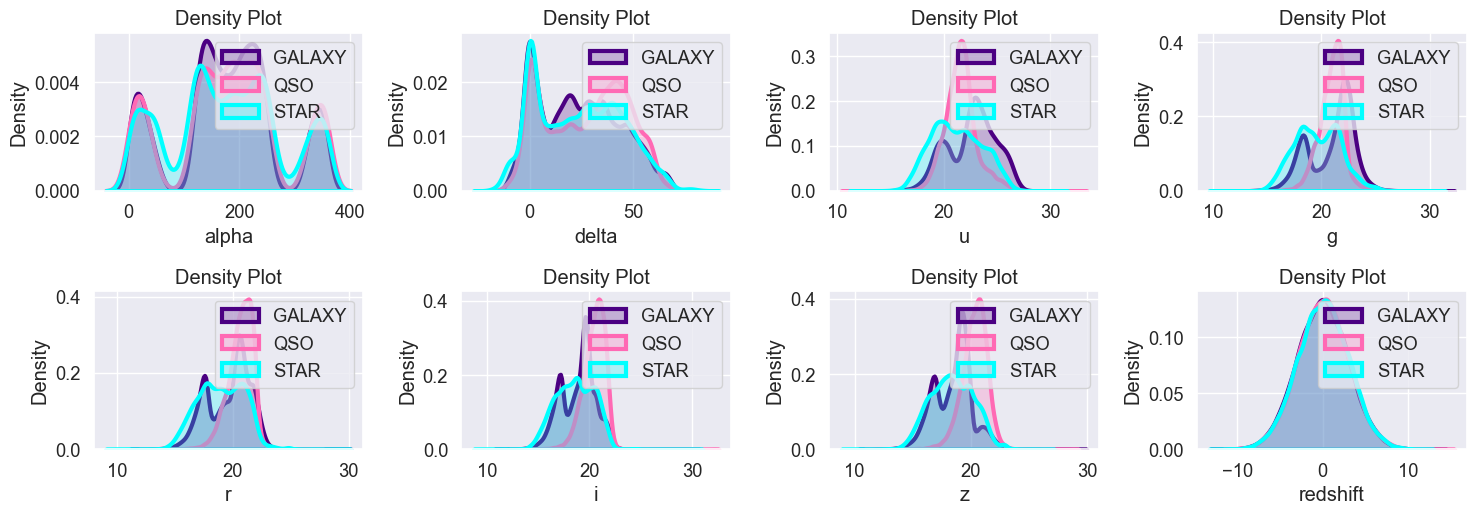

In [91]:
#How they are distributed
featurecols = list(features)
astrObjs = df_clean['class'].unique()
colours = ['indigo', '#FF69B4', 'cyan']
plt.figure(figsize=(15,10))
for i in range(len(featurecols)):
    plt.subplot(4, 4, i+1)
    for j in range(len(astrObjs)):
        sns.distplot(df_clean[df_clean['class']==astrObjs[j]][featurecols[i]], hist = False, kde = True, color = colours[j], kde_kws = {'shade': True, 'linewidth': 3}, label = astrObjs[j])
    plt.legend()
    plt.title('Density Plot')
    plt.xlabel(featurecols[i])
    plt.ylabel('Density')
plt.tight_layout()

Random Forest Classifier

In [92]:
#split the dataset
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=123, stratify=labels)
clf = RandomForestClassifier()

In [ ]:
#scale the data to speed up Random Forest
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train_scaled = scaling.transform(x_train)
x_test_scaled = scaling.transform(x_test)

Hyperparameter Optimisation

In [ ]:
#Parameters of RandomForest
pprint(clf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
#tuning using Random Search
hyperparameters = {'max_features':[None, 'auto', 'sqrt', 'log2'],
                   'max_depth':[None, 1, 5, 10, 15, 20],
                   'min_samples_leaf': [1, 2, 4],
                   'min_samples_split': [2, 5, 10],
                   'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                   'criterion': ['gini', 'entropy']}
rf_random = RandomizedSearchCV(clf, hyperparameters, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
rf_random.fit(x_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 1, 5, 10, 15, 20],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=123, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 80,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': None,
 'criterion': 'entropy'}

Training the RandomForest

In [99]:
clf.set_params(criterion = 'entropy', max_features = None, max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 80)

RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=80)

Cross Validation Score

In [ ]:
#Best Parameters
from sklearn.model_selection import cross_val_score

cross_score = cross_val_score(clf,features,labels,cv = 5,scoring = "accuracy")
print(f' Scores for each fold are: {cross_score}')
print(f' Average score: {"{:.2f}".format(cross_score.mean())}')

 Scores for each fold are: [0.8644  0.87675 0.8712  0.87145 0.86445]
 Average score: 0.87


In [93]:
#Experiment 1
clf.set_params(criterion = 'entropy', max_features = None, max_depth = 14, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 1)

cross_score = cross_val_score(clf,features,labels,cv = 5,scoring = "accuracy")
print(f' Scores for each fold are: {cross_score}')
print(f' Average score: {"{:.2f}".format(cross_score.mean())}')

 Scores for each fold are: [0.81345    0.8209     0.8259     0.8135     0.81344067]
 Average score: 0.82


In [ ]:
#Experiment 2
clf.set_params(criterion = 'entropy', max_features = None, max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50)

cross_score = cross_val_score(clf,features,labels,cv = 5,scoring = "accuracy")
print(f' Scores for each fold are: {cross_score}')
print(f' Average score: {"{:.2f}".format(cross_score.mean())}')

 Scores for each fold are: [0.8655  0.87685 0.87135 0.8709  0.8643 ]
 Average score: 0.87


Test and Evaluation

In [100]:
from sklearn.metrics import accuracy_score, f1_score

clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
sortedlabels = clf.classes_


In [101]:
print('features importances are : ' , clf.feature_importances_)

features importances are :  [0.06116929 0.05919991 0.13028411 0.23262843 0.11097141 0.06591006
 0.30156485 0.03827194]


<BarContainer object of 8 artists>

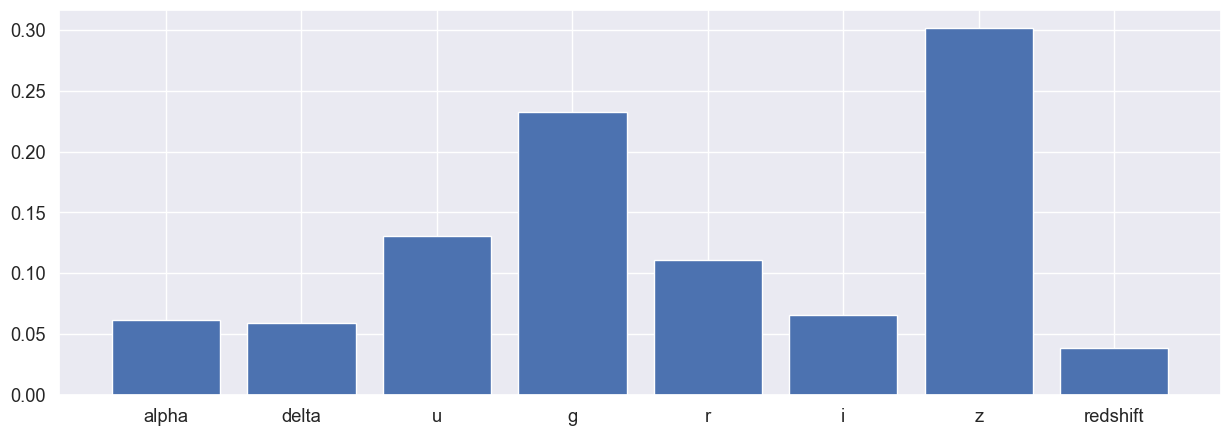

In [102]:
#Visualize feature importance
key=features.keys()
plt.figure(figsize=(15,5))
plt.bar(key,clf.feature_importances_)

Classification report and confusion matrix

In [103]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
print(cm)

              precision    recall  f1-score   support

      GALAXY       0.91      0.95      0.93     17834
         QSO       0.81      0.80      0.80      5688
        STAR       0.83      0.75      0.79      6478

    accuracy                           0.88     30000
   macro avg       0.85      0.83      0.84     30000
weighted avg       0.88      0.88      0.88     30000

[[16881   474   479]
 [  607  4559   522]
 [  983   615  4880]]


Visualization of Confusion Matrix

Text(43.25, 0.5, 'True')

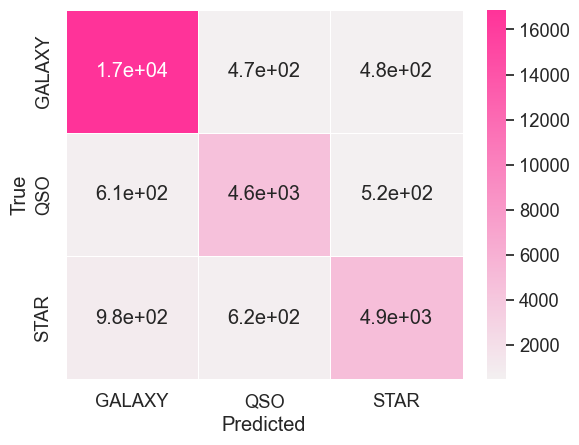

In [104]:
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.2)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6),n_colors=10000), annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')